In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F

import refsr
import numpy as np

import images as I
import utils as U

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import os

from PIL import Image

In [2]:
os.getcwd()

'D:\\Josm\\Workspace\\ComputerVision\\SRNTT\\ctrltt'

In [3]:
is_cuda=True
sr_model = refsr.get_default_sr_model(cuda=is_cuda)
vgg_model = refsr.get_default_vgg_model(cuda=is_cuda)
method = refsr.RefSR(sr_model, vgg_model)

In [4]:
def match_image_and_segmentation(img, segmap):
    assert img.dim() == 3
    assert segmap.dim() == 3

    _, H_img, W_img = img.size()
    _, H_seg, W_seg = segmap.size()

    H, W = min(H_img, H_seg), min(W_img, W_seg)

    return img[:, :H, :W], segmap[:, :H, :W]

In [5]:
size=160
dx, dy = 160, 160

x_hr=I.load_image("samples/img_001_SRF_8_HR.png")
x_hr_seg=I.torch.load("samples/img_001_SRF_8_HR_bic.pth")
x_hr, x_hr_seg = match_image_and_segmentation(x_hr, x_hr_seg)

x_hr = x_hr[:, dx:dx+size, dy:dy+size]
x_hr_seg = x_hr_seg[:, dx:dx+size, dy:dy+size]

x=I.load_image("samples/img_001_SRF_8_HR.png", resize_scale=0.25)[:, dx//4:(dx+size)//4, dy//4:(dy+size)//4]
x_seg = method.downscale(x_hr_seg.unsqueeze(0)).squeeze(0)

r1=I.load_image("samples/img_047_SRF_8_HR.png")
r1_seg=I.torch.load("samples/img_047_SRF_8_HR_bic.pth")
r1, r1_seg = match_image_and_segmentation(r1, r1_seg)

r2=I.load_image("samples/img_068_SRF_8_HR.png")
r2_seg=I.torch.load("samples/img_068_SRF_8_HR_bic.pth")
r2, r2_seg = match_image_and_segmentation(r2, r2_seg)

# r3=I.load_image("samples/000_3.png")[0]
# r4=I.load_image("samples/000_4.png")[0]

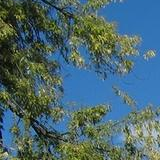

In [6]:
I.to_pil_image(x_hr)[0][0]

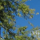

In [7]:
I.to_pil_image(x)[0][0]

In [8]:
# sr_model.cpu()
# vgg_model.cpu()
with torch.no_grad():
    if is_cuda:
        y=method.upscale_with_ref_with_seg(
            x=x.cuda(),
            x_seg=x_seg.cuda(),
            refs=U.cuda_all(r1, r2),
            refs_seg=U.cuda_all(r1_seg, r2_seg),
        )
    else:
        y=method.upscale_with_ref_with_seg(
            x=x,
            x_seg=x_seg,
            refs=(r1, r2),
            refs_seg=(r1_seg, r2_seg),
        )
I.to_pil_image(y)[0][0]

patches.size() torch.Size([96520, 256, 3, 3])

Doing classidx 00

Doing layer 1
CondH=40, CondW=40
RH=1, RW=1
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=38, Addr_W=38
Subset torch.Size([2653, 256, 3, 3])
PatchSize torch.Size([2653, 256, 3, 3])
NewPatch_H=3, NewPatch_W=3
outputs.size torch.Size([256, 40, 40])
counts.size torch.Size([40, 40])
last_i=37, last_i_start=37, last_i_end=40
last_j=37, last_j_start=37, last_j_end=40

Doing layer 2
CondH=40, CondW=40
RH=2, RW=2
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=38, Addr_W=38
Subset torch.Size([2653, 128, 6, 6])
PatchSize torch.Size([2653, 128, 6, 6])
NewPatch_H=6, NewPatch_W=6
outputs.size torch.Size([128, 80, 80])
counts.size torch.Size([80, 80])
last_i=37, last_i_start=74, last_i_end=80
last_j=37, last_j_start=74, last_j_end=80

Doing layer 3
CondH=40, CondW=40
RH=4, RW=4
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=38, Addr_W=38


RuntimeError: CUDA out of memory. Tried to allocate 3.31 GiB (GPU 0; 8.00 GiB total capacity; 3.94 GiB already allocated; 1.27 GiB free; 1023.16 MiB cached)

In [ ]:
with torch.no_grad():
    if is_cuda:
        y2=method.upscale_with_ref(
            x=x.cuda(),
            refs=U.cuda_all(r1, r2)
        )
    else:
        y2=method.upscale_with_ref(
            x=x,
            refs=(r1, r2)
        )
I.to_pil_image(y2)[0][0]